#Model Ensembling
By Chris Fenaroli, Delaney Granizo-Mackenzie, and Max Margenot 

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.

---

## What is Model Ensembling?

Model ensembling is the name for a variety of methods which combine information from many *independent* prediction models to obtain results with more predictive power than any of its components alone. The logic which an ensemble uses to combine them into a final prediction can in some techniques be very complicated, but the benefits of ensembling can be taken advantage of with a method as simple as an equally weighted average of independent predictions.

Ensembling plays a vital role in developing accurate predictive models and even employing basic ensembling techniques can in many cases drastically improve predictive performance. 

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import scipy.stats as stats
import scipy.linalg as linalg
from statsmodels import regression
import statsmodels.api as sm

## Why Combine Models?

A common approach to model selection is a "winner takes all" process where the best single model is chosen to make predictions. While intuitive and more interpretable than an ensemble, selecting only a single model to base predictions upon has weaknesses as follows:

* Diversifying your prediction through ensembling reduces variance of predictions
* Should a model begin failing, a large ensemble prevents it from greatly affecting predictions while a single-model approach would be ruined
* Helps prevent overfitting by not assigning any single approach a significant amount of weight 

### Caveats

Important to note is that the benefits of model ensembling will only be seen if the models being combined are at least somewhat independent. Aggregating many very similar models will have a much smaller benefit than aggregating ones with very distinct insights.

Let's define two $I.I.D.$ (independent and identically distributed) standard normal toy models `m_1` and `m_2`, and see what happens to their mean and standard deviation when we average their predictions over 1000 simulations.

---- Mean ----                          ---- Variance ----      
Model 1:        0.036                    Model 1:        1.02           
Model 2:        0.045                    Model 2:        0.946          
Combined:       0.041                    Combined:       0.486          

Covariance between models: -0.0109611639748


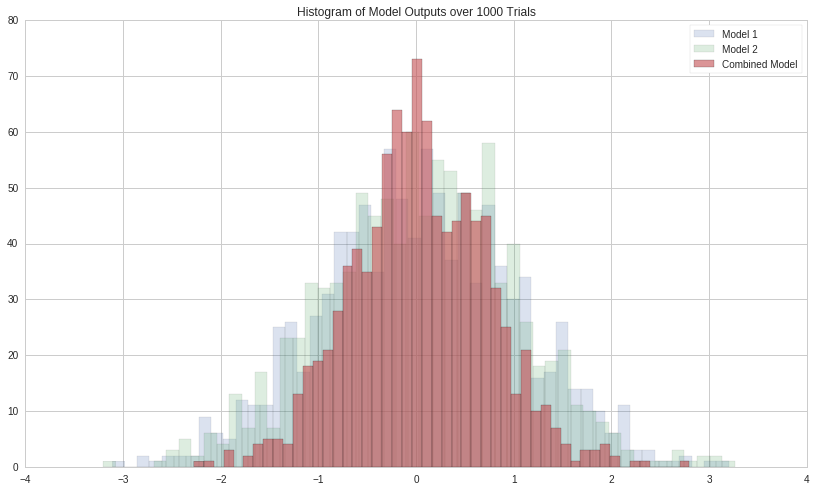

In [107]:
# Model parameters
mu = 0
sigma = 1

# Create two identical models
m_1 = np.random.normal(mu,sigma,1000)
m_2 = np.random.normal(mu,sigma,1000)

# Combine them
m_cm = (m_1 + m_2)/2

# Plot their distribution over 1000 trials
plt.hist(m_1, bins=50, alpha=0.2);
plt.hist(m_2, bins=50, alpha=0.2);
plt.hist(m_cm, bins=50, alpha=0.6);
plt.legend(['Model 1', 'Model 2', 'Combined Model'])
plt.title('Histogram of Model Outputs over 1000 Trials')

print "%-39s %-24s" % ('---- Mean ----', '---- Variance ----')
print "%-15s %-24s %-15s %-15s" % ('Model 1:', 
                                   np.round(np.mean(m_1),decimals=3), 
                                   'Model 1:', 
                                   np.round(np.std(m_1)**2,decimals=3))
print "%-15s %-24s %-15s %-15s" % ('Model 2:', 
                                   np.round(np.mean(m_2),decimals=3), 
                                   'Model 2:', 
                                   np.round(np.std(m_2)**2,decimals=3))
print "%-15s %-24s %-15s %-15s" % ('Combined:', 
                                   np.round(np.mean(m_cm),decimals=3),
                                   'Combined:',
                                   np.round(np.std(m_cm)**2,decimals=3))
print "\nCovariance between models:", np.cov(m_1, m_2)[1][0]

## Benefits of Ensembling: Symbolic Intuition

When the $I.I.D.$ models are aggregated, the mean stays the same while the variance of results decreases. Can this be explained symbolically? 

Consider two models with the same mean $m$, the same variance $v$, and zero covariance:

$$ models = \hat{\theta_1} \: , \: \hat{\theta_2}$$

$$E[\hat{\theta_1}]=E[\hat{\theta_2}]=m \:\:\:\:\:\:\:\: Var[\hat{\theta_1}] = Var[\hat{\theta_2}] = v \:\:\:\:\:\:\:\: Cov[\hat{\theta_2},\hat{\theta_2}] = 0$$

When averaged they form a combined model $\hat{\theta_{cm}}$: 

$$\hat{\theta_{cm}} = \frac{\hat{\theta_1} + \hat{\theta_2}}{2}$$ 

$$E[\hat{\theta_{cm}}] = \frac{E[\hat{\theta_1}]+E[\hat{\theta_2}]}{2} = m$$

$$Var[\hat{\theta_{cm}}] = \frac{Var[\hat{\theta_{1}}]+Var[\hat{\theta_{2}}]+2Cov[\hat{\theta_{1}},\hat{\theta_{2}}]}{4} = \frac{v}{2}$$

*Where the combined model keeps the same mean $m$ as its components but sees a reduction in variance.*

### Importance of Model Independence

Should the models being aggregated have a correlation of 1 (equivalent to a covariance of $v$), the variability-reducing effect no longer applies. Instead, the $2Cov[\hat{\theta_{1}},\hat{\theta_{2}}]$ term becomes equal to $2v$ in turn making variance equal to it's original value $v$. The significance of this is that the magnitude of the variance remains unchanged should the models being combined be perfectly correlated, illustrating the importance of the models being uncorrelated.

### Averaging $n$ Models

Now let's look at a combined model $\hat{\theta_{cm}}$ that is the average of $n$ $I.I.D$ models.

$$\hat{\theta_{cm}} = \frac{\sum_{i=1}^{n}{\hat{\theta_i}}}{n}$$

$$Var[\hat{\theta_{cm}}] = \frac{\sum_{i=1}^{n}{Var[\hat{\theta_i}}] + 2\sum_{1 \le i<j \le n}^{n}{Cov[\hat{\theta_i},\hat{\theta_j}]}}{n^2} = \frac{nv}{n^2} = \frac{v}{n}$$

This shows how if the models are perfectly uncorrelated, the ensemble's variance will decrease geometrically. Let's go back to our simulation and increase the number of models being combined:

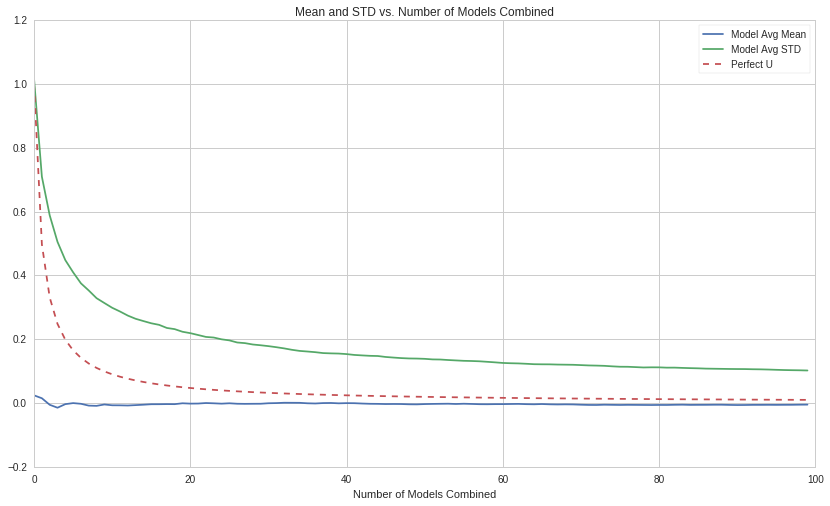

In [101]:
# Number of identical models
n = 100

# Initizalize n models
models = np.array([np.random.normal(mu,sigma,1000) for _ in range(n)])

combined_models = [np.mean(models[0:i+1], axis=0) for i in range(n)]
means = np.mean(combined_models,axis=1)
stds = np.std(combined_models,axis=1)

plt.plot(means);
plt.plot(stds);
plt.plot(range(n), 1/np.linspace(1,n+1,n), linestyle = '--')
plt.legend(['Model Avg Mean', 'Model Avg STD', 'Perfect U']);
plt.xlabel('Number of Models Combined');
plt.title('Mean and STD vs. Number of Models Combined');

As more models are added the mean predicted value is stationary and the prediction variability decreases geometrically. Worth noting, however, is that in this simulation the standard deviation did not decrease at the rate perfectly uncorrelated models would. This is a result of the toy models we used having some level of covariance, purely by random chance.



## Benefits of Ensembling: Dimension Intuition

The theory and simulation above demonstrate the benefits of simply averaging uncorrelated models; in both cases, as more models are averaged the mean stays the same but variance decreases. Model combination gets its power from the diversity of uncorrelated models ensuring that different features of the problem are represented. But what are these "features" that data apparently has? And how do combinations of diverse models help reveal them?

An interesting analogy is to think of a model as a specific "view" of the world, having its own perspective and unique insights into the problem at hand. Data can have many "dimensions" and rarely will one model encapture every single one; only by approaching it from many views can we understand its structure.

Consider a 3-dimensional object, such as a cylinder. To fully understand what this object is we require multiple perspectives from distinct viewpoints, as from each viewpoint alone you only see a 2-d projection of the space the cylinder takes up. To illustrate the limitations of attempting to understand a multi-dimensional structure from a single view, imagine looking at a cylinder from a specific viewpoint to the side and trying to decipher what it could be:

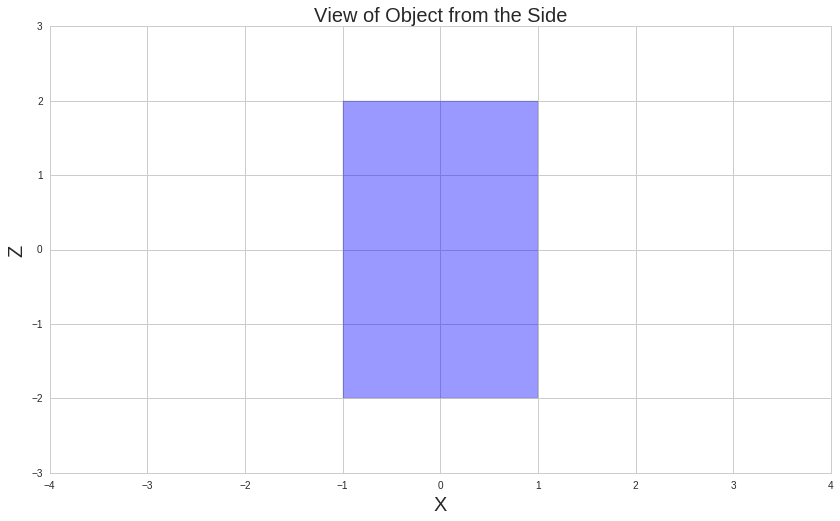

In [102]:
plt.fill_between([-1,0,1], -2, 2, facecolor='blue', alpha = 0.4);
plt.xlim(-4,4);
plt.ylim(-3,3);
plt.xlabel("X", fontsize=20);
plt.ylabel("Z", fontsize=20);
plt.title('View of Object from the Side', fontsize=20);

From this perspective alone we have no information on the object's presence in the $Y$ dimension; our only conclusion can be that the 3-d object is constrained in the $X$ and $Z$ dimensions by the rectangle defined by [-1,1] and [-2,2] respectively. 

Beyond that, we can not tell if the shape is a prism, cylinder, or any number of possible objects that fit those constraints. The "variability" of our understanding is high, and can only be diminished by supplementing our current perspective with an additional "view." 

Let's add another view by looking at the same object, this time from above instead of from the side:

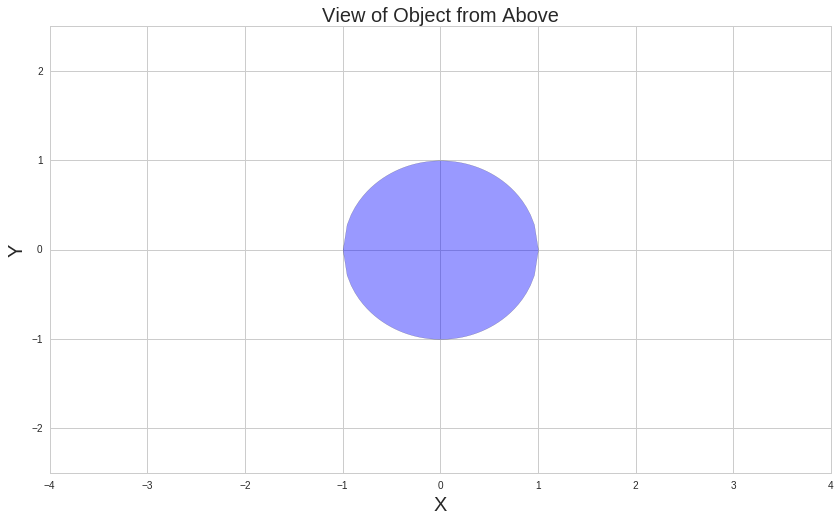

In [103]:
X = np.linspace(-1,1,50)
plt.fill_between(X, -np.sqrt(1-X**2), np.sqrt(1-X**2), facecolor='blue', alpha = 0.4);
plt.xlim(-4,4);
plt.ylim(-2.5,2.5);
plt.xlabel("X", fontsize=20);
plt.ylabel("Y", fontsize=20);
plt.title('View of Object from Above', fontsize=20);

After adding this second view we can be positive that the shape, if not a cylinder, is restricted to the space of
a cylinder with a unit circle base an height ranging from [-2,2].

Individually, neither of these perspectives would provide a particularly enlightening idea of the shape being looked at. With the first view, we had no information on the object in the $Y$ dimension, and in the second view we gained no information on the $Z$ dimension. When combined, however, we can make conclusions based on all three dimensions and the size of the set of possible shapes is drastically reduced. 

This is the idea behind model ensembling; the aggregation of multiple perspectives yields a more complete view than any of them alone.



## Multifamily Real Estate Example

Let's bring this analogy of uncorrelated models providing "perspectives" to one involving data. Where the cylinder above was a function of space in the $X$,$Y$, and $Z$ dimenseions, let's consider house pricing data, with possible explanatory dimensions `Number Of Stories`, `Total area`, and `Year Built`. 

The data was aggregated by user 'dmikebishop' on [DataWorld](https://data.world/dmikebishop/commercial-real-estate-for-sal). To use exterior data, store it as a CSV in the `data` folder in research and use the `local_csv` function to pull it into a Pandas DataFrame.

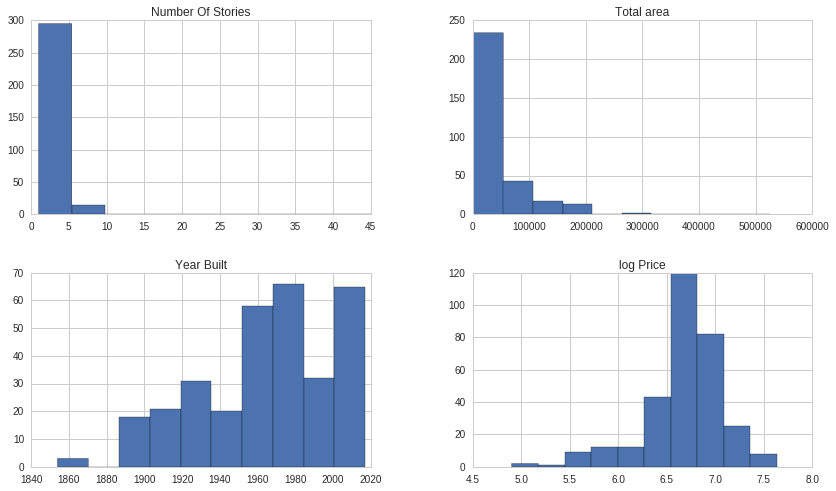

In [105]:
# Pulling in DataFrame and dropping blank values
fields = ['Price', 'Number Of Stories', 'Total area', 'Type', 'Year Built']
data = local_csv('loopnetlistingswithbrokers (3).csv')[fields]
data = data[data != ' '].dropna()

# Formatting values from strings with thousands separators into integers
data['Total area'] = data['Total area'].str.replace(' SF', '').str.replace(',','')
data['Price'] = data['Price'].str.replace(',','').str.replace('$', '')
data = data[[i.isdigit() for i in data['Price']]]
for i in [0,1,2,4]:
    data[fields[i]] = data[fields[i]].astype(int)

# Restricting the real estate to only multifamily properties
data = data[data['Type'] == 'Multifamily']

# Using log price transforms the price distribution to a more normal one
# Normally distributed independent variables are a linear regression assumption
data['log Price'] = np.log10(data['Price'])

data.ix[:, data.columns != 'Price'].hist(bins=10);

Let's begin by attempting to model `log Price` using only `Year Built` as our explanatory variable. We'll also define a linear regression plotting function to make this step simpler as we repeat it for the other data dimensions.

A OLS fitted simple linear regression returns a single set of coefficients that minimizes the sum of squared residuals within the training set. This model is simply an estimate. It will usually have bias (difference betwen model expected value and true value) and variance (sensitivity to small changes in the training set). As we add more models, we should see the aggregate model have a higher $R^2$ as the model leaves less and less variance in `log Price` unexplained.

rsquared 0.0190269927541


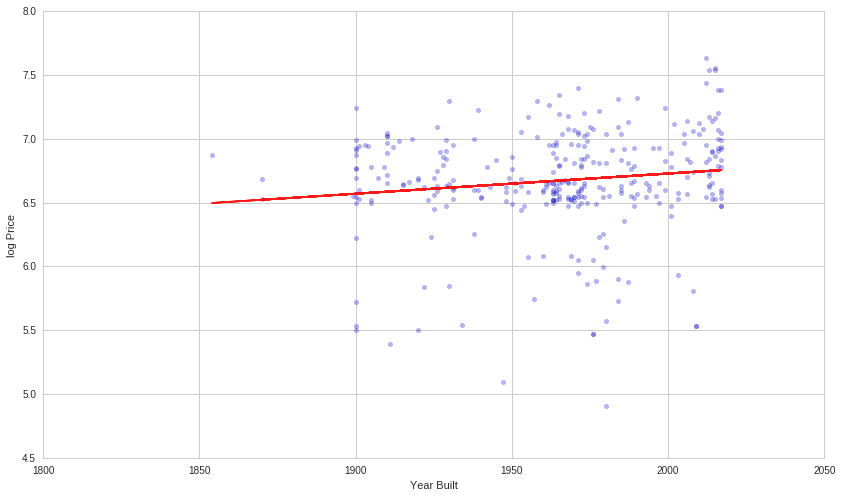

In [106]:
def linreg_r2(X,Y, plot):
    # Running the linear regression
    Xc = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, Xc).fit()
    params = model.params
    Y_hat = np.dot(Xc,params)
    
    # Plot results
    if plot:
        plt.scatter(X, Y, alpha=0.3) # Plot the raw data
        plt.plot(X, Y_hat, 'r', alpha=0.9);  # Add the regression line, colored in red
    return model.rsquared, Y_hat

print 'rsquared', linreg_r2(data['Year Built'], data['log Price'],plot=True)[0]
plt.xlabel('Year Built');
plt.ylabel('log Price');

Using only `Year Built` in our model explained only 1.9% of the variation on `log Price`. Using only one dimension to try and understand a multi-dimensional dataset is equivalent to trying to categorize a 3-d object as a cylinder by only approaching it from a single perspective. It cannot be done. In this model alone we ignore many features of the data and it can be improved by adding another dimension or 'view'.

Let's see what `log Price` looks like from the perspective of `Number Of Stories`:

rsquared 0.0561128798813


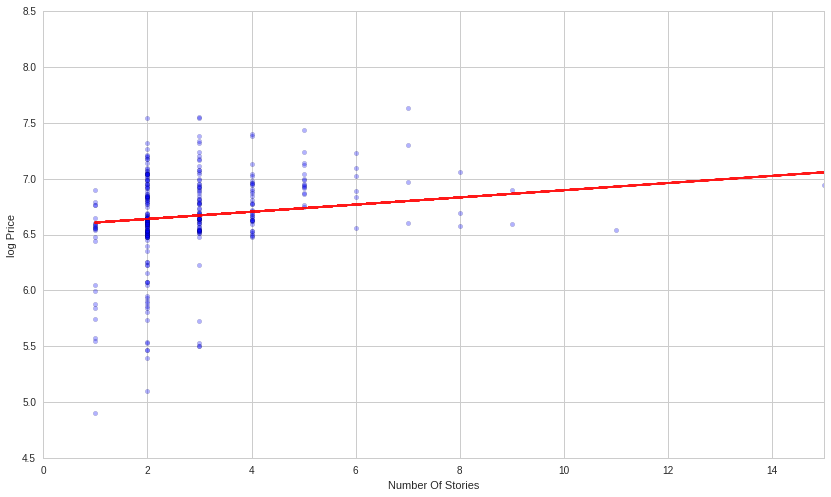

In [145]:
print 'rsquared', linreg_r2(data['Number Of Stories'], data['log Price'], plot=True)[0]
plt.xlabel('Number Of Stories');
plt.ylabel('log Price');
plt.xlim(0,15);

`Number Of Stories` explains about 5.6% of the variation in `log Price`. While better than `Year Built`, it still provides a mostly incomplete understanding. Let's take a look at the final dimension, `Total area`:

rsquared 0.168804441783


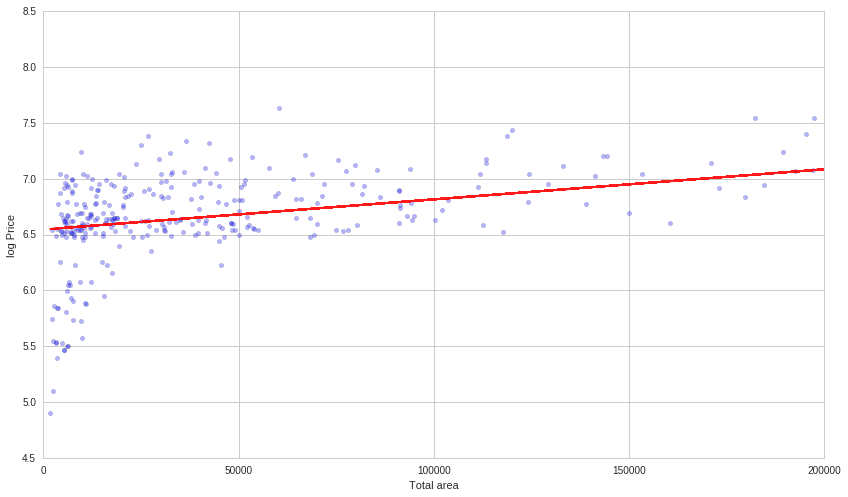

In [146]:
print 'rsquared', linreg_r2(data['Total area'], data['log Price'], plot=True)[0]
plt.xlabel('Total area');
plt.ylabel('log Price');
plt.xlim(0,200000);

`Total area` was the most insightful dimension, with its model explaining 16.8% of variance. Still, however, this is not a great result and we are still attempting to understand a complex, multidimensional dataset from a single perspective. Let's see if averaging the models, combining information from all 3 dimensions, can produce a more accurate model. 

*Note: In the below plot, the blue line is not the model but the line $Y=X$. Points along this line mean the combined model perfectly predicted the observed `log Price`.*

rsquared: 0.185624465575


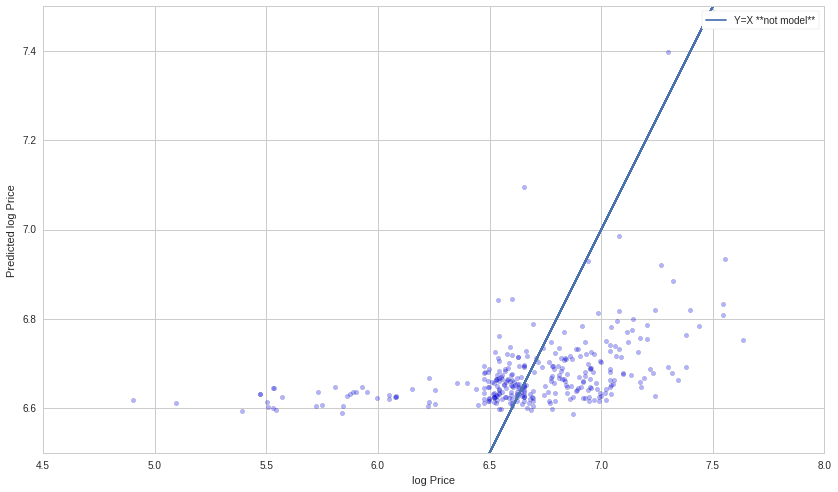

In [147]:
combined = (linreg_r2(data['Total area'], data['log Price'],plot=False)[1]
            + linreg_r2(data['Number Of Stories'], data['log Price'],plot=False)[1]
            + linreg_r2(data['Year Built'], data['log Price'],plot=False)[1])/3

plt.scatter(data['log Price'],combined, alpha = 0.3);
plt.plot(data['log Price'],data['log Price'], label='Y=X **not model**')
plt.ylim(6.5,7.5);
plt.xlabel('log Price');
plt.ylabel('Predicted log Price');
plt.legend();

print 'rsquared:', np.corrcoef(combined,data['log Price'])[0][1]**2

By taking a simple equally weighted average of all the models we saw $R^2$ increase to 18.6%. While still indicative of a poorly fit model, the result is still interesting considering the $R^2$ values of the individual single-dimension models were 1.9%, 5.6%, and 16.9% respectively. The $R^2$ of the combined model was higher than any of the single models alone.

Simply averaging the model outputs ignores some of the interplay between variables which can be better captured by using a multiple linear regression. Let's run a single multiple linear regression model on the pricing data:

rsquared: 0.188016012536


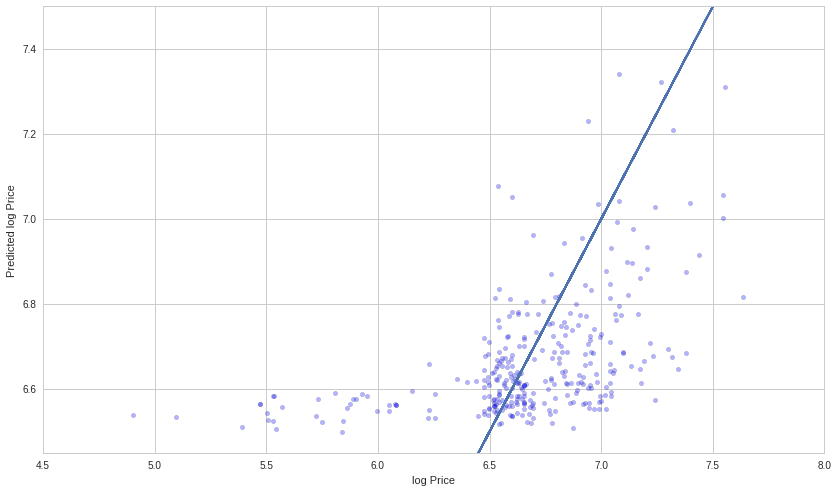

In [181]:
dimensions = [data['Number Of Stories'],data['Total area'],data['Year Built']]
mlr = linreg_r2(np.column_stack(dimensions), data['log Price'],plot=False)

print 'rsquared:', mlr[0]

plt.plot(data['log Price'], data['log Price'], label='Y=X **not model**');
plt.scatter(data['log Price'], mlr[1], alpha=0.3);
plt.xlabel('log Price');
plt.ylabel('Predicted log Price');
plt.ylim(6.45, 7.5);

This model performed slightly better than the aggregated model explaining 18.8% vs. 18.5% of variation in `log Price`. For more information on regression models with more than one explanatory variable, refer to the [Quantopian Lecture on Multiple Linear Regression](https://www.quantopian.com/lectures/multiple-linear-regression).

Despite our best efforts with the data we were given, the best model or combination of models we could generate only explained 18.8% of the variance in `log Price`. What this means is that the dimensions we were given (`Number Of Stories`, `Total area`, and `Year Built`) were not enough to give us a good understanding of what drives multifamily development prices. While dissapointing, this makes perfect sense as none of our models included important dimensions such as:

* Location desireability
* Lot size
* Number of family units
* Occupancy rate
* ...and probably many more

Furthermore, oftentimes datasets do not have obvious principal dimensions. In this situation you must develop a set of many possible influencers and whittle it down to only the most significant ones through [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction). 

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*